In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from Bio import SeqIO, Seq

import glob, os, yaml, subprocess, itertools, sparse, sys
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from statsmodels.distributions.empirical_distribution import ECDF
import sklearn.metrics
from sklearn.decomposition import PCA
import timeit
import scipy.stats as st
import pickle, yaml, tracemalloc
from scipy.stats import binomtest

drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
drugs_loci = pd.read_csv("../data/drugs_loci.csv")
eigenvec_df = pd.read_csv("../data/eigenvec_100PC.csv").set_index("sample_id")
pca_explained_var = np.load("../data/pca_explained_var.npy")
who_variants_combined = pd.read_csv("../analysis/who_confidence_2021.csv")

sample_ids_mapping = pd.read_csv("../data/sample_ids_mapping.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")
drug_CC = pd.read_csv("../data/drug_CC.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
input_data_dir = '/n/data1/hms/dbmi/farhat/ye12/who'
who_variants_combined = pd.read_csv("../analysis/who_confidence_2021.csv")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False).query("sample_id in @eigenvec_df.index & ~Coll2014.str.contains(',')")
lineages.shape

In [ ]:
for i, row in lineages.iterrows():
    
    if row["Coll2014"][0].isnumeric():
        lineages.loc[i, "Lineage"] = row["Coll2014"][0]
    else:
        lineages.loc[i, "Lineage"] = row["Coll2014"]

In [ ]:
drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

# Make Pie Chart of Lineages

## Manually add other stuff to the pie chart, like lineage name and percentage on the chart itself

In [17]:
lineage_summary = pd.DataFrame(lineages["Lineage"].value_counts())

other_cols = ["5", "6", "7", "BOV_AFRI", "BOV", "canetti"]
lineage_summary.loc["5,6,7,Other", ["Lineage"]] = [lineage_summary.loc[other_cols]["Lineage"].sum()]

lineage_summary = lineage_summary.reset_index().rename(columns={"index":"Lineage", "Lineage": "Count"})
lineage_summary = lineage_summary.sort_values("Lineage", ascending=True)
lineage_summary = lineage_summary.query("Lineage not in @other_cols")

lineage_summary["Count"] = lineage_summary["Count"].astype(int)

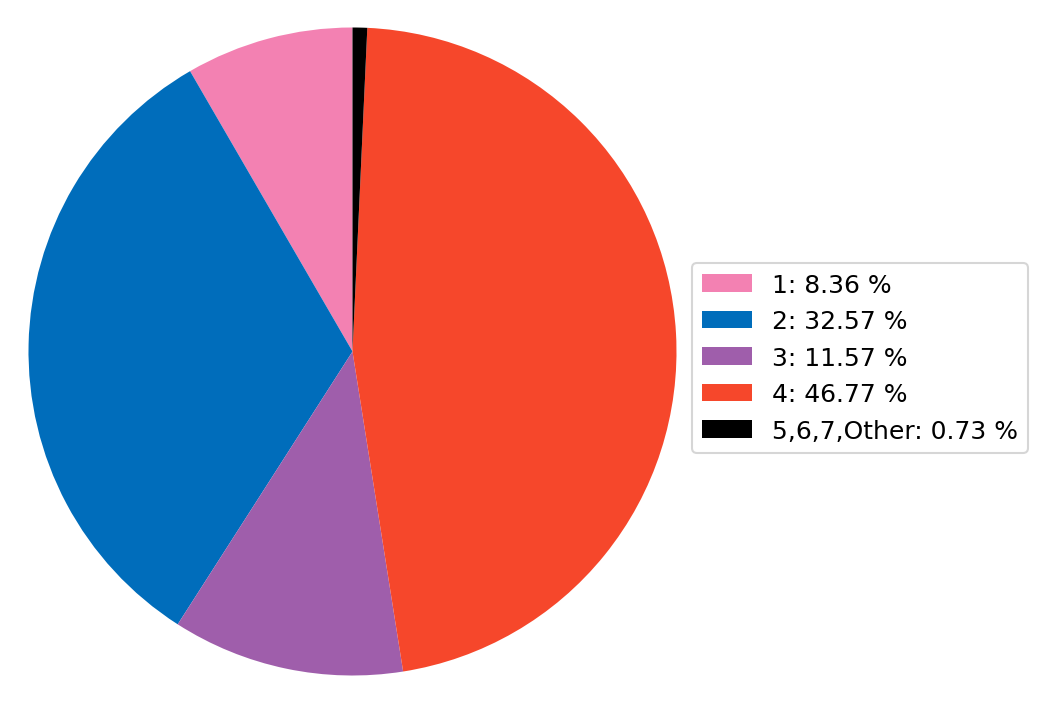

In [28]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = lineage_summary["Lineage"]
sizes = lineage_summary["Count"]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots()
# ax.pie(sizes, #explode=explode, 
#        labels=labels, autopct='%1.0f%%', startangle=90)
# ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   # "5": "#76400e",
                   # "6": "#36ba74",
                   # "7": "#ffb000",
                   "5,6,7,Other": "black",
                  }

colors = [LinToColor_Dict[lineage] for lineage in lineage_summary["Lineage"].values]

wedge_sizes = 100.*sizes/sizes.sum()
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
labels = ['{0}: {1:1.2f} %'.format(i,j) for i,j in zip(labels, wedge_sizes)]

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.tight_layout()
plt.legend(patches, labels)

sns.move_legend(ax, fontsize=12, title='', loc='upper right', bbox_to_anchor=(1.52, 0.65))
# sns.despine()
plt.savefig("Figures/lineage_pie.png", dpi=400, bbox_inches='tight')

# Exploded Pie Chart for Sublineages of L2 and L4 (Focus on L2.2.1 later on)

https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html

In [53]:
L2_samples = []

for i, row in lineages.iterrows():
    
    if "," in row["Coll2014"]:
        split = row["Coll2014"].split(",")
        
        for val in split:
            if val.startswith("2"):
                L2_samples.append(row["sample_id"])
                lineages.loc[i, "L2"] = val
                break
    else:
        if row["Coll2014"].startswith("2"):
            L2_samples.append(row["sample_id"])
            lineages.loc[i, "L2"] = row["Coll2014"]
            
print(len(L2_samples), lineages.shape)

16041 (49113, 8)


In [60]:
lineage_col = "L2"
L2_summary = pd.DataFrame(lineages.query("sample_id in @L2_samples")[lineage_col].value_counts())

other_cols = ["2", "2.1", "2.2"]
L2_summary.loc["2,2.1,2.2", [lineage_col]] = [L2_summary.loc[other_cols][lineage_col].sum()]
L2_summary.loc["2.2.1", [lineage_col]] = [L2_summary.loc[["2.2.1", "2.2.1.1", "2.2.1.2"]][lineage_col].sum()]

L2_summary = L2_summary.reset_index().rename(columns={"index": "Lineage", lineage_col: "Count"}).query("Lineage not in @other_cols")
L2_summary = L2_summary.query("Lineage not in ['2.2.1.1', '2.2.1.2']")

L2_summary = L2_summary.sort_values("Lineage", ascending=True)
L2_summary

,Lineage,Count
7,"2,2.1,2.2",140.0
0,2.2.1,15062.0
2,2.2.2,839.0


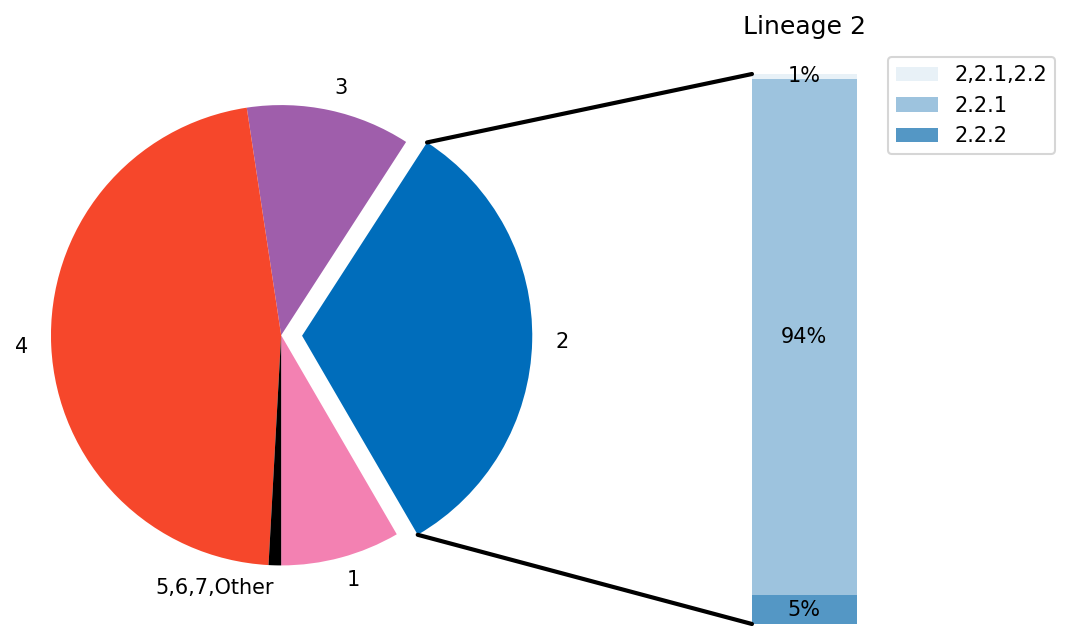

In [61]:
wedge_idx = 1

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = wedge_sizes.values
labels = lineage_summary["Lineage"]
explode = np.zeros(len(labels))
explode[wedge_idx] = 0.1

# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[wedge_idx]
wedges, *_ = ax1.pie(overall_ratios, colors=colors, startangle=270, radius=1.1,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = L2_summary["Count"].values/L2_summary["Count"].sum() #[.33, .54, .07, .06]
age_labels = L2_summary["Lineage"].values
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate([*zip(age_ratios, age_labels)]):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + (1/len(age_ratios)) * j
                )
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Lineage 2')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[wedge_idx].theta1, wedges[wedge_idx].theta2
center, r = wedges[wedge_idx].center, wedges[wedge_idx].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.savefig("Figures/L2_breakdown.png", dpi=300)

# Distribution of Resistance Across Drugs

In [14]:
df_resistance = pd.DataFrame(columns=["Drug", "Resistant", "Susceptible"])

for i, drug in enumerate(os.listdir(analysis_dir)):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    df_resistance.loc[i, :] = [drug, len(df_phenos.query("phenotype==1")), len(df_phenos.query("phenotype==0"))]
    
df_resistance["Total"] = df_resistance["Resistant"] + df_resistance["Susceptible"]
df_resistance = df_resistance.sort_values("Total", ascending=False)

df_resistance["R_prop"] = df_resistance["Resistant"] / df_resistance["Total"]
df_resistance["S_prop"] = df_resistance["Susceptible"] / df_resistance["Total"]
df_resistance["ABBR"] = df_resistance["Drug"].map(drug_abbr_dict)

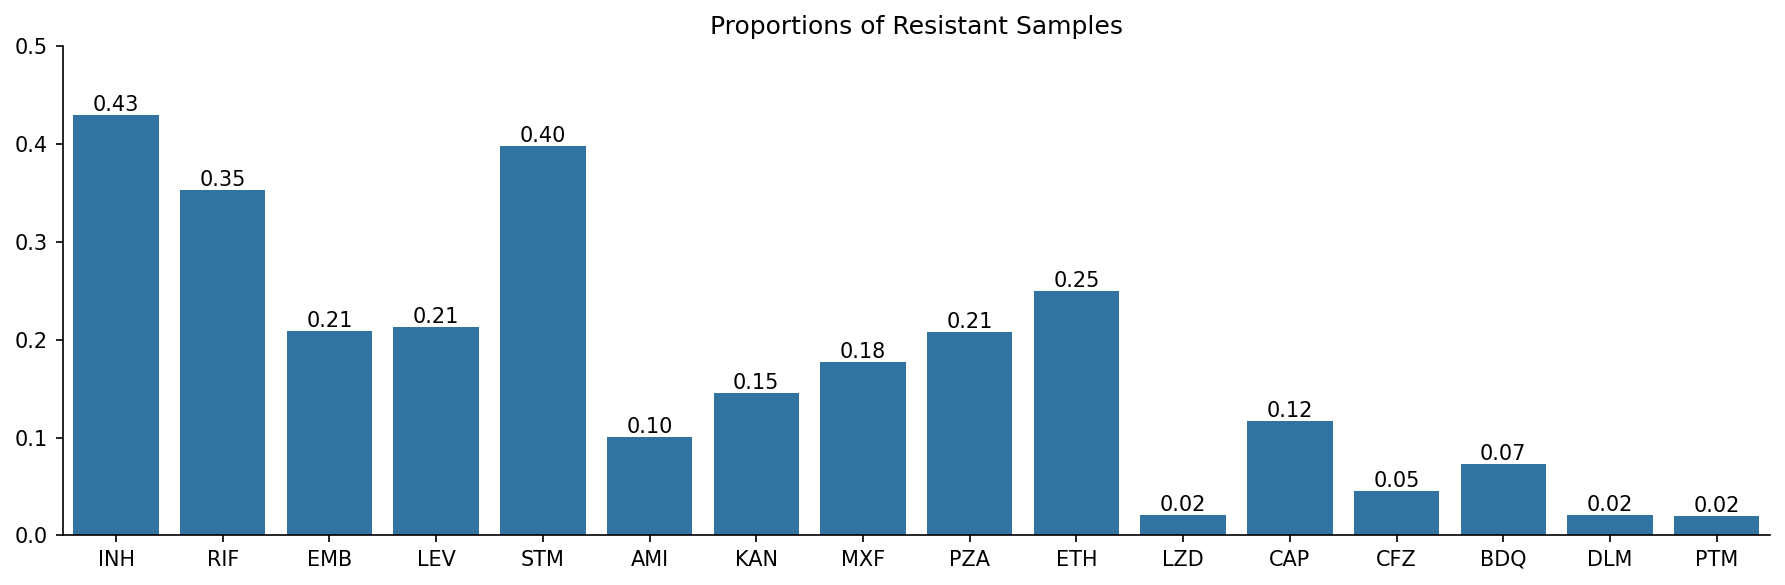

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=df_resistance, x="ABBR", y="R_prop", color='#1f77b4', ax=ax)
ax.bar_label(ax.containers[0], fmt='%.2f')

# plt.xticks(rotation=60)
plt.xlabel("")
plt.ylabel("")
plt.title("Proportions of Resistant Samples")
sns.despine()
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig("Figures/resistance_summary.png", dpi=300)

In [16]:
#df_resistance.set_index('Drug')[["R_prop", "S_prop"]].plot(kind='bar', stacked=True, color=['steelblue', 'red'])

# MDR- and XDR-TB Metrics

2021 Updates to pre-XDR and XDR definitions: https://www.who.int/news/item/27-01-2021-who-announces-updated-definitions-of-extensively-drug-resistant-tuberculosis

<ul>
    <li>MDR: RIF and INH</li>
    <li>pre-XDR: MDR + any fluoroquinolone</li>
    <li>XDR: MDR + any fluoroquinolone + Group A drug (levofloxacin, moxifloxacin, bedaquiline and linezolid)</li>
</ul>


Group A drugs are the most potent group of drugs in the ranking of second-line medicines for the treatment of drug-resistant forms of TB using longer treatment regimens.

In [62]:
combined_phenos = pd.DataFrame(columns=["Drug", "sample_id", "phenotype"])

for drug in os.listdir(analysis_dir):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    df_phenos["Drug"] = drug
    combined_phenos = pd.concat([combined_phenos, df_phenos[["Drug", "sample_id", "phenotype"]]], axis=0)
    
combined_phenos = combined_phenos.pivot(index="sample_id", columns="Drug", values="phenotype")
print(f"{len(combined_phenos)} samples passed QC")

/tmp/ipykernel_26141/1559956348.py:9: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  combined_phenos = combined_phenos.pivot(index="sample_id", columns="Drug", values="phenotype")


52567 samples passed QC


In [64]:
MDR = combined_phenos.query("Rifampicin==1 & Isoniazid==1").index.values
len(MDR)

15709

In [65]:
total = len(combined_phenos.loc[(~pd.isnull(combined_phenos["Rifampicin"])) & (~pd.isnull(combined_phenos["Isoniazid"]))])

In [66]:
RIF_R = len(combined_phenos.loc[(~pd.isnull(combined_phenos["Rifampicin"])) & (combined_phenos["Rifampicin"]==1)])
RIF_R / total

0.35893560404470465

In [67]:
INH_R = len(combined_phenos.loc[(~pd.isnull(combined_phenos["Isoniazid"])) & (combined_phenos["Isoniazid"]==1)])
INH_R / total

0.4460031931878659

In [68]:
pre_XDR = combined_phenos.query("Rifampicin==1 & Isoniazid==1 & (Levofloxacin==1 | Moxifloxacin==1)").index.values
len(pre_XDR)

5261

In [69]:
combined_phenos.loc[(~pd.isnull(combined_phenos["Rifampicin"])) & 
                    (~pd.isnull(combined_phenos["Isoniazid"])) &
                    (~pd.isnull(combined_phenos["Levofloxacin"])) & 
                    (~pd.isnull(combined_phenos["Moxifloxacin"]))
                   ].shape

(18737, 16)

In [70]:
combined_phenos.loc[(~pd.isnull(combined_phenos["Rifampicin"])) & 
                    (~pd.isnull(combined_phenos["Isoniazid"])) &
                    (~pd.isnull(combined_phenos["Levofloxacin"])) & 
                    (~pd.isnull(combined_phenos["Moxifloxacin"])) &
                    (~pd.isnull(combined_phenos["Bedaquiline"])) & 
                    (~pd.isnull(combined_phenos["Linezolid"]))
                   ].shape

(11907, 16)

In [71]:
# for XDR, there are 2 minimum cases: 1) MDR + BOTH fluoroquinolones, 2) MDR + 1 fluoroquinolone + 1 of BDQ and LZD
XDR = set(combined_phenos.query("Rifampicin==1 & Isoniazid==1 & Levofloxacin==1 & Moxifloxacin==1").index).union(combined_phenos.query("Rifampicin==1 & Isoniazid==1 & (Levofloxacin==1 | Moxifloxacin==1) & (Bedaquiline==1 | Linezolid==1)"))
len(XDR)


2911

combined_phenos_PCA = combined_phenos.merge(eigenvec_df, left_index=True, right_index=True).merge(lineages.set_index("Sample_ID")[["Primary_Lineage", "Lineage_1", "Lineage_2"]],
                                                                                                  left_index=True, right_on="Sample_ID", how="inner"
                                                                                                 )# Lineage Analysis

Color Picker: https://imagecolorpicker.com/en

Copy-pasted this image in: https://www.nature.com/articles/nrmicro.2018.8/figures/1

In [ ]:
lineages.shape

In [ ]:
eigenvec_df.merge(lineages[["sample_id", "Lineage"]]), left_index=True, right_on="sample_id")

In [ ]:
combined_phenos_PCA = combined_phenos.merge(eigenvec_df, left_index=True, right_index=True).merge(lineages.query("~Coll2014.str.contains(',')").set_index("sample_id")[["Lineage"]],
                                                                                                  left_index=True, right_index=True, how="inner"
                                                                                                 )

# LinToColor_Dict = {"1": "#DF83AC",
#                    "2": "#7098CB",
#                    "3": "#815D9F",
#                    "4": "#E76956",
#                    "5": "#B67548",
#                    "6": "#6AB79E",
#                    "7": "#E4515B",
#                   }
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                  }

sns.scatterplot(data=combined_phenos_PCA.query("Lineage in ['1', '2', '3', '4', '5', '6', '7']"), 
                x="PC8", y="PC96", 
                hue="Lineage",
                hue_order=['1', '2', '3', '4', '5', '6', '7'],
                palette=LinToColor_Dict,
                alpha=0.7,
                )

# sns.scatterplot(data=combined_phenos_PCA.query("Lineage in ['2']"), 
#                 x="PC8", y="PC9", 
#                 hue="Lineage_1",
#                 #hue_order=['1', '2', '3', '4', '5', '6', '7'],
#                 #palette=LinToColor_Dict,
#                 alpha=0.7,
#                 )

plt.tight_layout()
plt.legend(loc="best", fontsize=10)
sns.despine()
#plt.savefig("Figures/PC0_PC1.png", dpi=300)
plt.show()

In [ ]:
lineages.shape

In [ ]:
combined_phenos_PCA = combined_phenos.merge(eigenvec_df, left_index=True, right_index=True).merge(lineages.set_index("sample_id")[["Lineage"]],
                                                                                                  left_index=True, right_index=True, how="inner"
                                                                                                 )

# LinToColor_Dict = {"1": "#DF83AC",
#                    "2": "#7098CB",
#                    "3": "#815D9F",
#                    "4": "#E76956",
#                    "5": "#B67548",
#                    "6": "#6AB79E",
#                    "7": "#E4515B",
#                   }
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                  }

sns.scatterplot(data=combined_phenos_PCA.query("Lineage in ['1', '2', '3', '4', '5', '6', '7']"), 
                x="PC0", y="PC1", 
                hue="Lineage",
                hue_order=['1', '2', '3', '4', '5', '6', '7'],
                palette=LinToColor_Dict,
                alpha=0.7,
                )

# sns.scatterplot(data=combined_phenos_PCA.query("Lineage in ['2']"), 
#                 x="PC8", y="PC9", 
#                 hue="Lineage_1",
#                 #hue_order=['1', '2', '3', '4', '5', '6', '7'],
#                 #palette=LinToColor_Dict,
#                 alpha=0.7,
#                 )

plt.tight_layout()
plt.legend(loc="best", fontsize=10)
sns.despine()
#plt.savefig("Figures/PC0_PC1.png", dpi=300)
plt.show()

# Prediction Models: Compare if Adding Tier 2 Mutations Improves Model Fit using LRT

Inclusion criteria: categories 1, 2, 4, or 5. So mutations had to have LRT_BH_pval < thresh, Num_Isolates ≥ 5, and PPV_LB ≥ 0.25 to be in the model.

In [89]:
def fit_single_CV_model(drug, tier2_bool, phenos_name, lrt=True):
    
    scaler = StandardScaler()
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).query(f"phenotypic_category==@phenos_name")
    
    
    #################### SEPARATE TIER 1 AND TIER 2 MUTATIONS AND SLICE MATRIX ####################
    
    matrix = pd.read_pickle(os.path.join(analysis_dir, drug, f"BINARY/prediction_models/significant_mut_matrix.pkl"))
    matrix = matrix.loc[matrix.index.isin(df_phenos["sample_id"])]
    
    if not tier2_bool:
        genes = drug_gene_mapping.query("Drug==@drug & Tier == 1").Gene.values
        matrix = matrix[matrix.columns[matrix.columns.str.contains("|".join(genes))]]

    matrix = matrix[matrix.columns[~((matrix == 0).all())]]
    
    # Delamanid problem. The only significant mutation only came up in ALL phenos
    if matrix.shape[1] > 0:
        df_phenos = df_phenos.set_index("sample_id").loc[matrix.index]
        assert sum(matrix.index != df_phenos.index.values) == 0

        X = scaler.fit_transform(matrix.values)
        y = df_phenos["phenotype"].values

        ########################## FIT MODEL ##########################

        model = LogisticRegressionCV(Cs=np.logspace(-6, 6, 13), 
                                     cv=5,
                                     penalty='l2',
                                     max_iter=10000, 
                                     multi_class='ovr',
                                     scoring='neg_log_loss',
                                     class_weight='balanced'
                                    )

        model.fit(X, y)

        # get positive class probabilities and predicted classes after determining the binarization threshold
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = get_threshold_val_and_classes(y_prob, y)

        if lrt:
            log_like = -sklearn.metrics.log_loss(y_true=y, y_pred=y_prob, normalize=False)
            return matrix.columns, log_like
        else:
            auc = sklearn.metrics.roc_auc_score(y_true=y, y_score=y_prob)
            acc = sklearn.metrics.accuracy_score(y_true=y, y_pred=y_pred)
            balanced_acc = sklearn.metrics.balanced_accuracy_score(y_true=y, y_pred=y_pred)
            return auc, acc, balanced_acc
        
    else:
        return np.nan, np.nan, np.nan

In [90]:
def perform_LRT_for_tiers(drug, phenos_name):
    
    tier1_feat, tier1_log_like = fit_single_CV_model(drug, False, phenos_name, lrt=True)
    tier12_feat, tier12_log_like = fit_single_CV_model(drug, True, phenos_name, lrt=True)

    # check that tier1_feat is a subset of tier12_feat
    assert len(set(tier1_feat) - set(tier12_feat)) == 0
    assert len(set(tier1_feat).intersection(tier12_feat)) == len(tier1_feat)
    
    # null hypothesis is that Tier 1 + 2 log-like > Tier 1 log-like. Larger log-like is a better model
    # degrees of freedom is the difference in the number of parameters between the two models
    chi_stat = 2 * (tier12_log_like - tier1_log_like)
    pval = 1 - st.chi2.cdf(x=chi_stat, df=len(tier12_feat) - len(tier1_feat))
    return pval, tier1_feat, tier12_feat, list(set(tier12_feat) - set(tier1_feat))

In [1]:
import shutil

In [4]:
for drug in os.listdir(analysis_dir):
    shutil.rmtree(os.path.join(analysis_dir, drug, "BINARY/prediction_models"))

In [5]:
os.path.join(analysis_dir, drug)

'/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Ethionamide'